# Import Dependency


In [18]:
import tensorflow
import sys

import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model,load_model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.callbacks import TensorBoard

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import pandas as pd
import numpy as np
from numpy import ndarray
import matplotlib
import math
import json

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import json
from datetime import datetime

import os.path
from os import path

print("Python: ", sys.version)
print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("keras: ", tensorflow.keras.__version__)
print("tensorflow: ", tensorflow.__version__)

## Parameter 

In [19]:
# Dataset path
DATA_TRAIN_PATH = 'dataset/normal/04nov-24nov.csv' #normal

ENCODING = "ISO-8859-1" # csv encoding
DATE_COL_NAME = 'date'

LOG_EXPORT_PATH = 'log/'
if path.exists(LOG_EXPORT_PATH) == False:
  !mkdir LOG_EXPORT_PATH
  os.mkdir(LOG_EXPORT_PATH)

PLOT_EXPORT_PATH = 'plot/'
if path.exists(PLOT_EXPORT_PATH) == False:
  !mkdir PLOT_EXPORT_PATH
  os.mkdir(PLOT_EXPORT_PATH)

# scaler
SCALER = MinMaxScaler(feature_range = (0,1))
PLOT_VISIBLE = True
PLOT_SIZE = (12, 6)
PLOT_SAVE = True
TEST_SPACE = 10

RESULT_DATA = []*8 #temporary result data
RESULT_THRESHOLD = []*8 #temporary result threshold

sensors = [
    "date", #0
    "Excitation Field Current", #1
    "Excitation Field Voltage", #2
    "Power Factor", #3
    "Reactive Power", #4
    "Generator Gross Capacity", #5
]

seasonals = [
    "Trend",
    "Seasonal",
    "Residual"
]

test_types = ['extreme','variance','shift','trend']

## Fungsi - Fungsi

### Fungsi Reshape Data

In [20]:
def Reshape(df_input, prefix=''):
  
  # change to datetime format
  df_input['date'] = pd.to_datetime(df_input['date'])
  
  # sort datetime
  df_input.sort_values(by='date', ascending=True, inplace=True)

  # make datetime as index
  df_input.set_index('date', drop=True, inplace=True)

  # resample to avoid missing data or timeseries (convert to zeros). Also can be used to  reduce data
  df_input = df_input.resample('1min').sum() # (1) .sum() make no value in lookup become 0. (2) 1min = 1 minute

  #if zeros means missing data change into NAN, 
  df_input[df_input.columns] = df_input[df_input.columns].replace(0, np.nan)
  
  #check NaN
  nan_counts = [df_input[col].isnull().sum() for col in df_input.columns]

  # Fill NaN Using Interpolate
  if sum(nan_counts) > 0:
    df_input.interpolate(method='spline', order=3, limit=max(nan_counts), limit_direction='both', inplace=True)

  if PLOT_VISIBLE:
    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure(figsize=(24,12))
    ax = fig.add_subplot(111)
    ax.set_prop_cycle('color', [cm(1.*i/len(df_input.columns)) for i in range(len(df_input.columns))])
    for col_name in df_input.columns:
        ax.plot(df_input[col_name])
    plt.legend(df_input.columns, ncol=int(math.ceil(len(df_input.columns)/10)),  bbox_to_anchor=(1, 1))
    plt.title('Original '+prefix+'Data')
    plt.savefig(PLOT_EXPORT_PATH + prefix + 'Data Original.jpg')  
    plt.show()

  return df_input

### Fungsi MinMaxScaller

In [34]:
def FitScaler(df_input):
  scaler = MinMaxScaler(feature_range = (0,1))
  df_scaled = scaler.fit_transform(df_input.values.reshape(-1,1))
  
  return df_scaled, scaler

### Fungsi Split Seasonal Decompose

In [22]:
def SplitSeasonalDecompose(df_input, prefix=''):
  df_split = seasonal_decompose(df_input, period=1440, model="additive", extrapolate_trend='freq') 
  #model menggunakan "additive" (pertambahan) karena terdapat nilai 0. "multiplicative" (Perkalian)  tidak bisa jika terdapat value 0
  #1440 dari menit perhari

  if PLOT_VISIBLE:
    plt.figure(figsize=(24,3))
    plt.plot(df_split.trend)
    plt.title(prefix + '_Trend')
    plt.savefig(PLOT_EXPORT_PATH +prefix + '_Trend.jpg')
    plt.show()

    plt.figure(figsize=(24,3))
    plt.plot(df_split.seasonal)
    plt.title(prefix + '_Seasonal')
    plt.savefig(PLOT_EXPORT_PATH +prefix + '_Seasonal.jpg')
    plt.show()

    plt.figure(figsize=(24,3))
    plt.plot(df_split.resid)
    plt.title(prefix + '_Residual')
    plt.savefig(PLOT_EXPORT_PATH +prefix + '_Residual.jpg')
    plt.show()
    
  return df_split.trend, df_split.seasonal, df_split.resid

### Fungsi Inverse Scaler

In [23]:
def InverseScaler(df_input,scaler):
  df_inverse = scaler.inverse_transform(df_input)
  return df_inverse

### Fungsi Fit LSTM

In [24]:
# fit an LSTM network to training data
def FitLstm(df_train, df_validation, n_unit, n_batch, n_epoch, n_time_steps, prefix=''):
  model = Sequential()
  model.add(LSTM(n_unit, input_shape=(n_time_steps,1), return_sequences=True))
  model.add(Dense(1, activation='sigmoid'))
  # model.add(Dense(1))
  model.compile(optimizer='adam', loss=METRIC)
  model.summary()

  model_log = model.fit(x=df_train, y=df_train,
            batch_size = n_batch,
            epochs = n_epoch,
            verbose=1,
            validation_data = (df_validation, df_validation),
            shuffle=False
            )
            
  json.dump(model_log.history, open(LOG_EXPORT_PATH+prefix, 'w'))
  model.save(LOG_EXPORT_PATH + 'Model ' + prefix + '.h5')
  
  plt.plot(model_log.history['loss'], marker='.',label='train')
  plt.plot(model_log.history['val_loss'], marker='.',label='validation')
  plt.title('Train vs validation_'+prefix)
  plt.legend()
  plt.savefig(PLOT_EXPORT_PATH + 'Train vs validation_'+prefix + '.jpg')
  plt.show()

  print('Model saved to: "',LOG_EXPORT_PATH + 'Model ' + prefix + '.h5"')

  return model, model_log

In [25]:
# fit an LSTM network to training data
def FitLstm2(df_train, df_validation, n_unit, n_batch, n_epoch, n_time_steps, prefix=''):
  model = Sequential()
  model.add(LSTM(n_unit, input_shape=(n_time_steps,1), return_sequences=True))
  model.add(LSTM(n_unit, input_shape=(n_time_steps,1), return_sequences=True))
  model.compile(optimizer='adam', loss=METRIC)
  model.summary()

  model_log = model.fit(x=df_train, y=df_train,
            batch_size = n_batch,
            epochs = n_epoch,
            verbose=1,
            validation_data = (df_validation, df_validation),
            shuffle=False
            )
            
  json.dump(model_log.history, open(LOG_EXPORT_PATH+prefix, 'w'))
  model.save(LOG_EXPORT_PATH + 'Model ' + prefix + '.h5')
  
  plt.plot(model_log.history['loss'], marker='.',label='train')
  plt.plot(model_log.history['val_loss'], marker='.',label='validation')
  plt.title('Model train vs validation loss '+prefix)
  plt.legend()
  plt.savefig(PLOT_EXPORT_PATH + 'Model train vs validation loss '+prefix + '.jpg')
  plt.show()

  print('Model saved to: "',LOG_EXPORT_PATH + 'Model ' + prefix + '.h5"')

  return model, model_log

In [26]:
# fit an LSTM network to training data
def FitLstm3(df_train, df_validation, n_unit, n_batch, n_epoch, n_time_steps, prefix=''):
  model = Sequential()
  model.add(LSTM(n_unit, input_shape=(n_time_steps,1), return_sequences=True))
  model.compile(optimizer='adam', loss=METRIC)
  model.summary()

  model_log = model.fit(x=df_train, y=df_train,
            batch_size = n_batch,
            epochs = n_epoch,
            verbose=1,
            validation_data = (df_validation, df_validation),
            shuffle=False
            )
            
  json.dump(model_log.history, open(LOG_EXPORT_PATH+prefix, 'w'))
  model.save(LOG_EXPORT_PATH + 'Model ' + prefix + '.h5')
  
  plt.plot(model_log.history['loss'], marker='.',label='train')
  plt.plot(model_log.history['val_loss'], marker='.',label='validation')
  plt.title('Model train vs validation loss '+prefix)
  plt.legend()
  plt.savefig(PLOT_EXPORT_PATH + 'Model train vs validation loss '+prefix + '.jpg')
  plt.show()
  
  print('Model saved to: "',LOG_EXPORT_PATH + 'Model ' + prefix + '.h5"')

  return model, model_log

### Fungsi Calculate Metric

In [27]:
def CalculateMetic(combined_test_result):
  sintetic_anomaly_location = test_param[test_type]['timestamps']

  index=0
  true_positive = 0
  anomaly_predicted = 0
  for anomaly in combined_test_result['anomaly']:
    if anomaly == 1:
      # print(index)
      for start, end in sintetic_anomaly_location:
        
        # cek pada sekitar area apakah ada anomali
        for sintetis_anomaly in range(start-TEST_SPACE, end+TEST_SPACE):
          if (index == sintetis_anomaly):
            # print('>>>>>',sintetis_anomaly)
            true_positive+=1
      anomaly_predicted+=1
    index+=1

  false_positive = anomaly_predicted - true_positive
  print('Anomaly Predicted: ',anomaly_predicted) #save
  print('True Positif: ',true_positive) #save
  print('False Positif: ',false_positive)
  print('Precision: ',(true_positive/(true_positive+false_positive)))
  
  return anomaly_predicted,true_positive

# Import dan Olah Data

## Import Train Data

Training Dataset Path:  ../dataset_ip/normal/blt2_04nov-24nov.csv


C:\Users\acer\AppData\Local\Temp\ipykernel_20532\429962211.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train_original = pd.read_csv(DATA_TRAIN_PATH, header=0, sep=';')


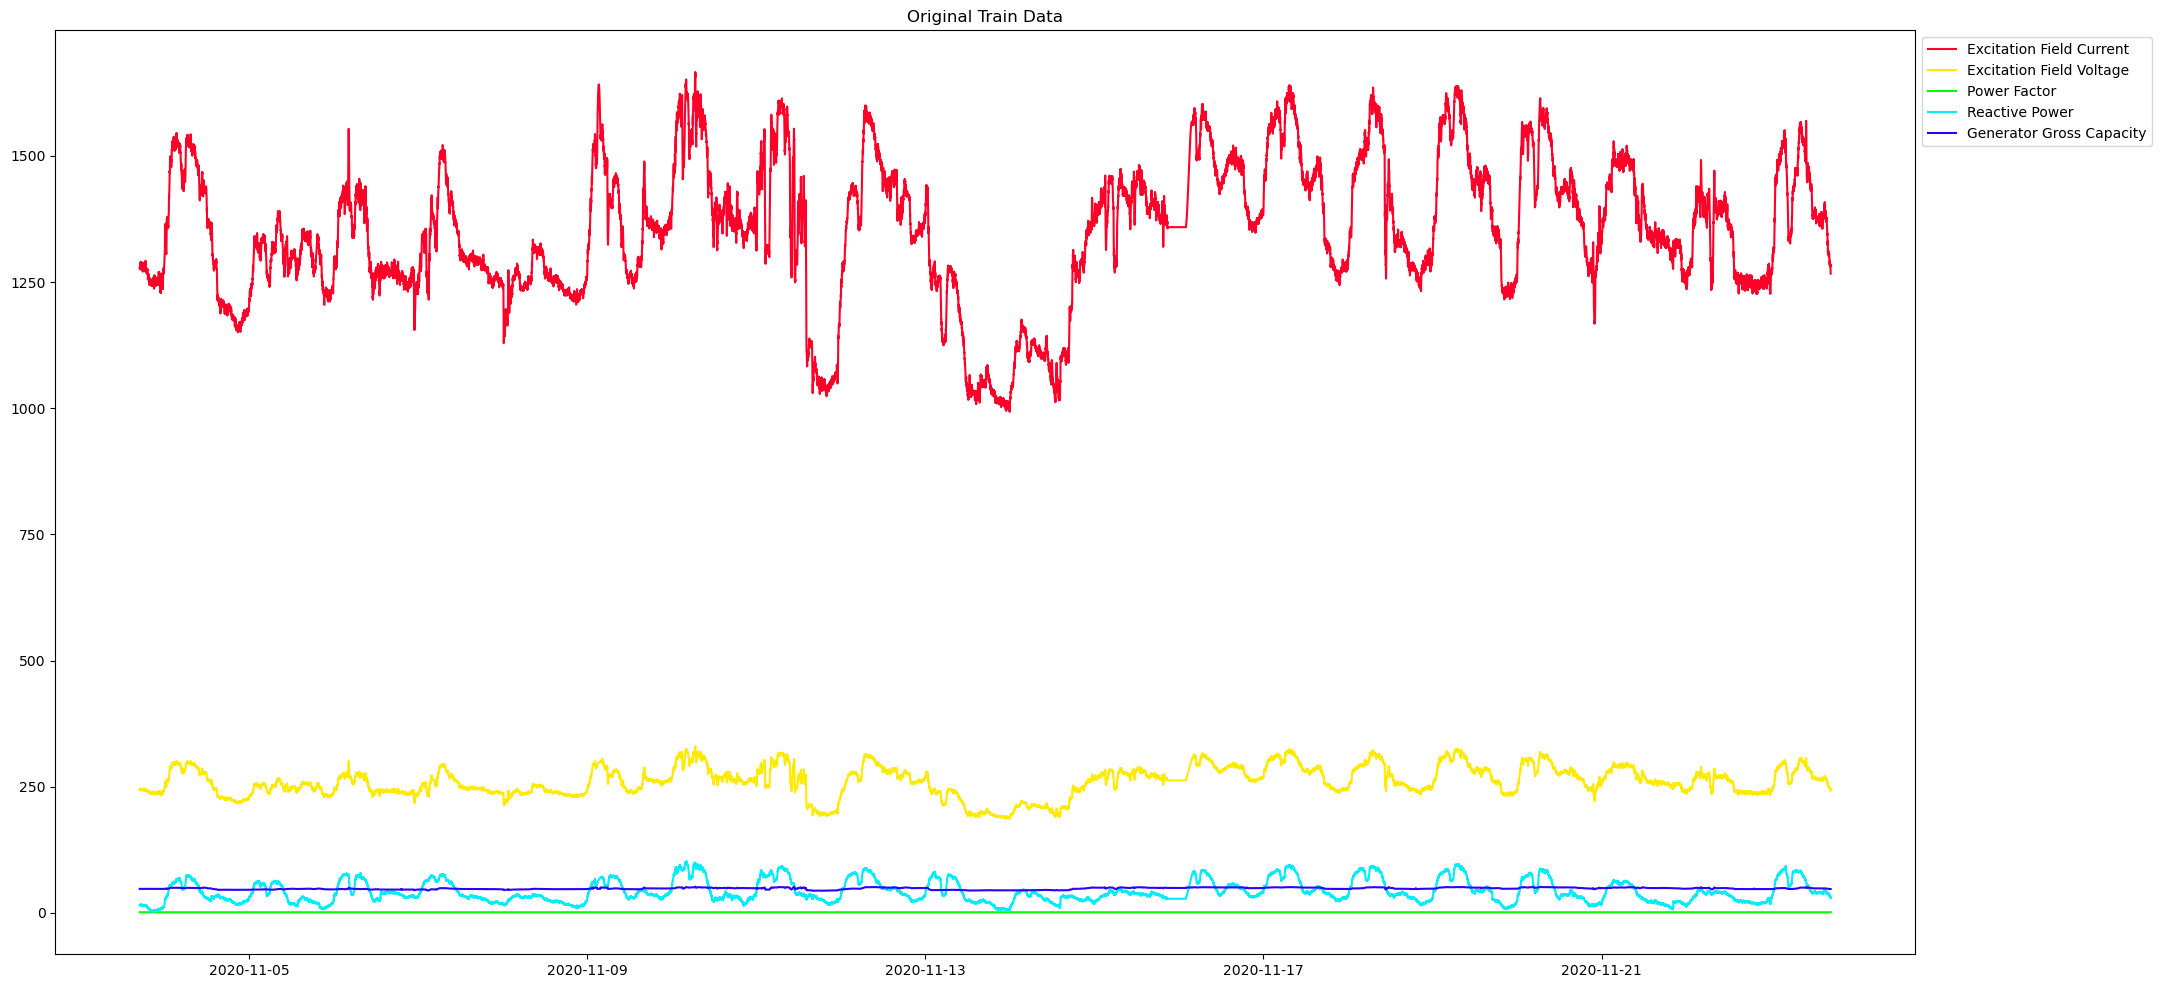

,Excitation Field Current,Excitation Field Voltage,Power Factor,Reactive Power,Generator Gross Capacity
date,,,,,
2020-11-03 17:01:00,1279.181641,243.693634,1.007328,15.343759,47.349918
2020-11-03 17:02:00,1275.686279,243.129669,1.007541,14.585219,47.351555
2020-11-03 17:03:00,1276.679077,242.692551,1.006973,14.489356,47.353813


In [28]:
print("Training Dataset Path: ", DATA_TRAIN_PATH)
df_train_original = pd.read_csv(DATA_TRAIN_PATH, header=0, sep=';')
df_train_original = df_train_original.loc[:, df_train_original.columns.intersection(sensors)]

#Reshape data
df_train_reshape = Reshape(df_train_original,'Train ')
df_train_reshape.head(3)

## Describe Data

In [29]:
for sensor in sensors:
  if sensor != DATE_COL_NAME:
    print(df_train_reshape[sensor].describe())

count    28800.000000
mean      1353.346540
std        136.836558
min        992.836365
25%       1264.899628
50%       1357.852234
75%       1450.042297
max       1665.812622
Name: Excitation Field Current, dtype: float64
count    28800.000000
mean       260.669964
std         29.292006
min        186.417099
25%        241.006180
50%        261.194824
75%        281.658905
max        329.333404
Name: Excitation Field Voltage, dtype: float64
count    28800.000000
mean         1.006719
std          0.002904
min          0.998446
25%          1.004498
50%          1.006237
75%          1.009033
max          1.016542
Name: Power Factor, dtype: float64
count    28800.000000
mean        42.442664
std         21.672493
min          1.814182
25%         26.366840
50%         36.910116
75%         58.291722
max        101.817894
Name: Reactive Power, dtype: float64
count    28800.000000
mean        48.044968
std          1.850996
min         43.584324
25%         46.810988
50%         48.19882

# Batch Training
Training akan dilakukan sebanyak jumlah sensor dikali 3 seasonal

In [35]:
#Parameter yang digunakan dalam proses perulangan training

METRIC = 'mean_absolute_error'
training_summary = []
n_repeat = 1

n_epochs = {
    'Trend':[20],
    'Seasonal': [20],
    'Residual':[20],
}

n_batchs = {
    'Trend':[32],
    'Seasonal':[32],
    'Residual':[64],
}
n_units = {
    'Trend':[64],
    'Seasonal':[32],
    'Residual':[16],
}

n_timesteps = {
    'Trend':[1440], #jumlah menit dalam 1 hari
    'Seasonal':[1440], #jumlah menit dalam 1 hari
    'Residual':[1440], #jumlah menit dalam 1 hari
}


| ========================================================================================== |
| Training Sensor:  Excitation Field Current
| > Sensor Start Time:  2023-05-19 08:19:16.563159 



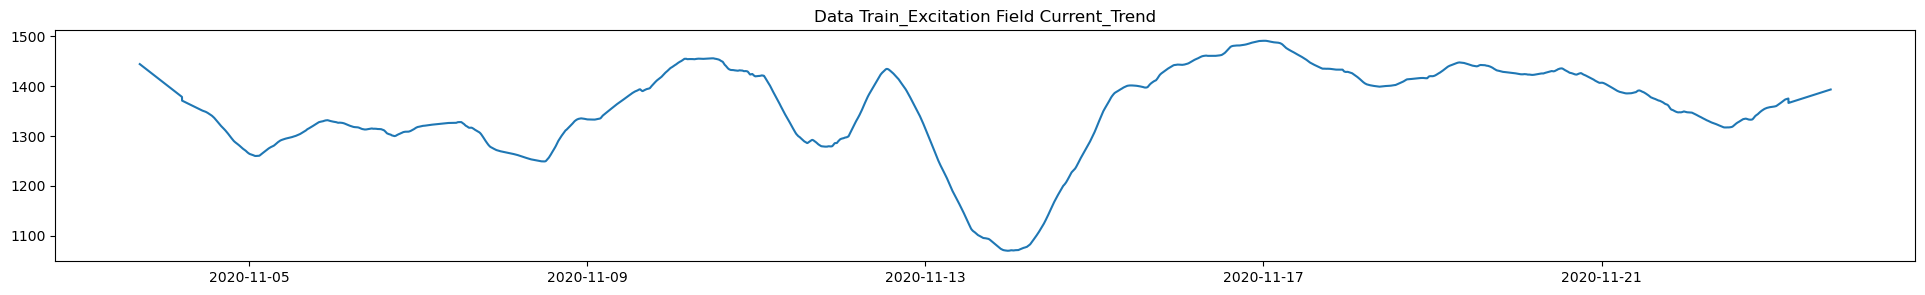

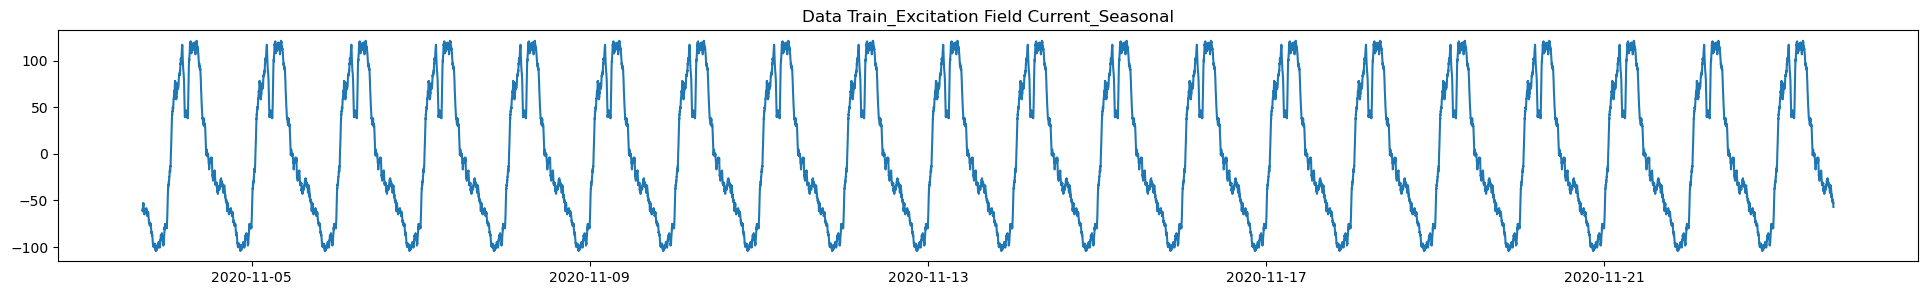

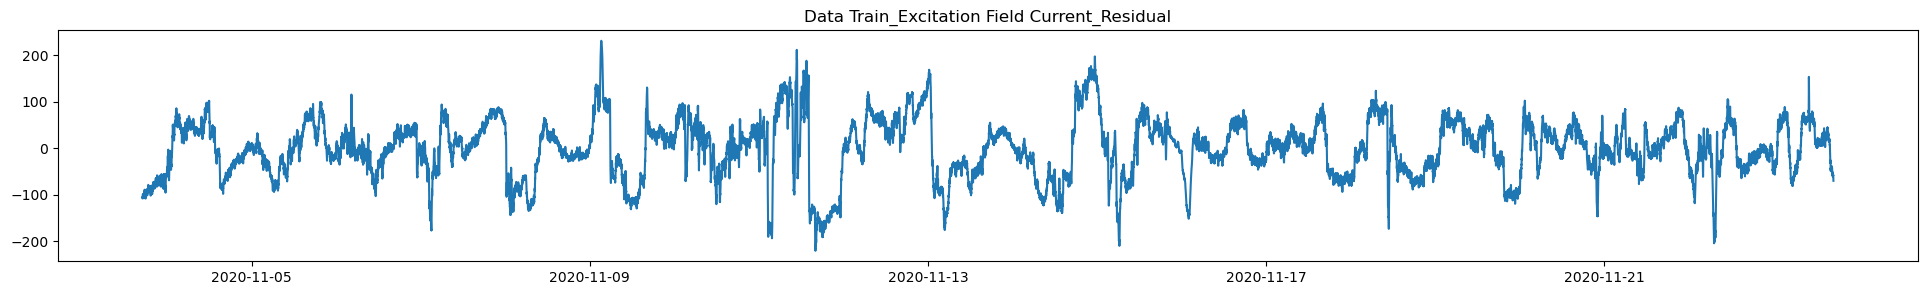

| __________________________________________________________________________________________ |
| >> Excitation Field Current_Trend Start Time:  2023-05-19 08:19:17.765156
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1440, 64)          16896     
                                                                 
 dense_15 (Dense)            (None, 1440, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
675/675 [==============================] - 6s 5ms/step - loss: 0.1445 - val_loss: 0.0624
Epoch 2/20
675/675 [==============================] - 2s 3ms/step - loss: 0.1104 - val_loss: 0.0524
Epoch 3/20
  1/675 [..............................] - ETA: 2s - loss: 0.04

KeyboardInterrupt: 

In [39]:
for sensor in sensors:
  if sensor != DATE_COL_NAME:
    print('\n| ========================================================================================== |')
    print('| Training Sensor: ',sensor)
    print('| > Sensor Start Time: ',datetime.now(),'\n')

    df_train = df_train_reshape[sensor].copy()
    # Split Seasonal
    df_train_trend, df_train_seasonal, df_train_residual = SplitSeasonalDecompose(df_train,'Data Train_'+sensor)
    # MinMaxScaled
    df_train_trend_scaled, transform_train_trend = FitScaler(df_train_trend)
    df_train_seasonal_scaled, transform_train_seasonal = FitScaler(df_train_seasonal)
    df_train_residual_scaled, transform_train_residual = FitScaler(df_train_residual)

    # Split data training & validation
    test_size = len(df_train) - int((len(df_train))*0.25)
    df_training_trend, df_validation_trend = df_train_trend_scaled[0:test_size], df_train_trend_scaled[test_size:len(df_train_trend_scaled)]
    df_training_seasonal, df_validation_seasonal = df_train_seasonal_scaled[0:test_size], df_train_seasonal_scaled[test_size:len(df_train_seasonal_scaled)]
    df_training_residual, df_validation_residual = df_train_residual_scaled[0:test_size], df_train_residual_scaled[test_size:len(df_train_residual_scaled)]

    for season in seasonals:
      for n_epoch in n_epochs[season]:
        for n_batch in n_batchs[season]:
          for n_unit in n_units[season]:
            for n_timestep in n_timesteps[season]:
              prefix = str(sensor)+'_'+season
              training_start = datetime.now()

              print('| __________________________________________________________________________________________ |')
              print('| >>',prefix,'Start Time: ',training_start) 
              
              model, model_log = FitLstm(df_training_trend, df_validation_trend, n_unit, n_batch, n_epoch, n_timestep, prefix)
              
              training_end = datetime.now()
              print('| >>',prefix,'End Time: ',training_end)  

              training_summary.append([
              sensor,
              season,
              '1L+1S',
              n_batch, 
              n_unit,
              n_timestep,
              n_epoch, 
              model_log.history['loss'][-1],
              model_log.history['val_loss'][-1],
              json.dumps(model_log.history['loss']),
              json.dumps(model_log.history['val_loss']),
              training_start,
              training_end
            ])
                 
    print('\n| > Sensor End Time: ',datetime.now())
    print('| ========================================================================================== |\n') 

In [41]:
#Save summary
export_summary = pd.DataFrame(training_summary,columns = ['Sensor','season','layer','batch','unit','timesteps','epoch','loss','vlost','Json loss','json vloss','time start','time end'])
export_summary

TIMESTAMP = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
export_summary.to_excel(LOG_EXPORT_PATH+'Training_summary('+TIMESTAMP+').xlsx', index=False)
print('Export to: '+LOG_EXPORT_PATH+'Training_summary('+TIMESTAMP+').xlsx')

Export to: log/Training_summary(2023-05-19_08-19-55).xlsx
